<a href="https://colab.research.google.com/github/KaustubhKaushik26/Sentiment-Analysis/blob/main/SentimentAnalysis_with_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

## Setting the environment

In [9]:
import tensorflow as tf
from tensorflow import keras


In [10]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM


from sklearn.model_selection import train_test_split

## Loading dataset

In [11]:
# Importing IMDb Movie Reviews dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/SentimentAnalysis/dataset/IMDB Dataset.csv'

movie_reviews = pd.read_csv(dataset_path)

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [12]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [13]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [14]:
# Checking for missing values

movie_reviews.isnull().values.any()

np.False_

<Axes: xlabel='sentiment', ylabel='count'>

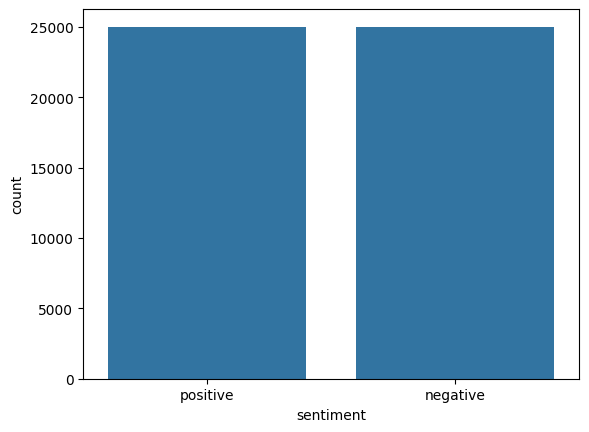

In [15]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [16]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [17]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [20]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [21]:
# Sample cleaned up movie review

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [22]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [24]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [25]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [26]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Loading Glove Embedding

In [28]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_embedding_path = '/content/drive/MyDrive/Colab Notebooks/SentimentAnalysis/dataset/glove.6B.100d.txt'
glove_file = open(glove_embedding_path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [29]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [30]:
embedding_matrix.shape

(92394, 100)

## Loading FastText Embedding

In [31]:
# Load FastText .vec file
fasttext_embedding_index = {}

fasttext_embedding_path = '/content/drive/MyDrive/Colab Notebooks/SentimentAnalysis/dataset/wiki-news-300d-1M.vec'

with open(fasttext_embedding_path, 'r', encoding='utf-8', errors='ignore') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        fasttext_embedding_index[word] = vector


In [32]:
# Create FastText embedding matrix of shape (vocab_length, 300)
fasttext_embedding_matrix = np.zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    vector = fasttext_embedding_index.get(word)
    if vector is not None:
        fasttext_embedding_matrix[index] = vector


# Model Training with:

# 1(a). Simple Neural Network with Glove Embedding

In [34]:
# Neural Network architecture

glove_snn_model = Sequential()
glove_embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

glove_snn_model.add(glove_embedding_layer)

glove_snn_model.add(Flatten())
glove_snn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
# Model compiling

glove_snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(glove_snn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [36]:
# Model training

glove_snn_model_history = glove_snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.6538 - loss: 0.6161 - val_acc: 0.7649 - val_loss: 0.5039
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.7970 - loss: 0.4485 - val_acc: 0.7531 - val_loss: 0.5133
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.8205 - loss: 0.4051 - val_acc: 0.7638 - val_loss: 0.4995
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8387 - loss: 0.3788 - val_acc: 0.7586 - val_loss: 0.5104
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.8439 - loss: 0.3636 - val_acc: 0.7601 - val_loss: 0.5189
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.8476 - loss: 0.3527 - val_acc: 0.7552 - val_loss: 0.5369


In [37]:
# Predictions on the Test Set

glove_snn_score = glove_snn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7428 - loss: 0.5697


In [38]:
# Model Performance

print("Test Score:", glove_snn_score[0])
print("Test Accuracy:", glove_snn_score[1])

Test Score: 0.5721777081489563
Test Accuracy: 0.7462000250816345


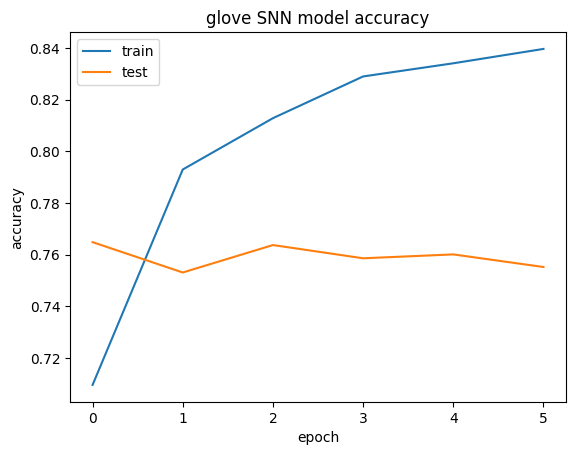

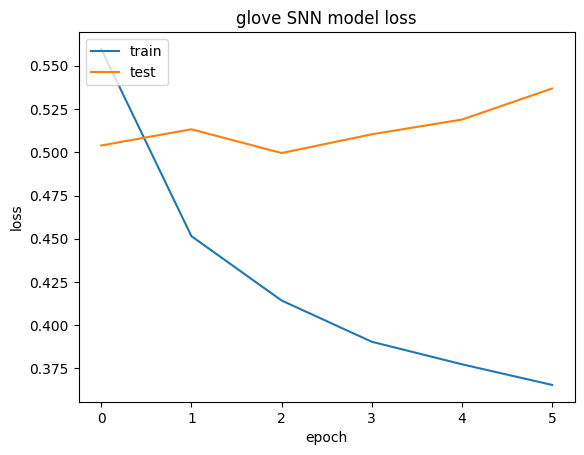

In [55]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(glove_snn_model_history.history['acc'])
plt.plot(glove_snn_model_history.history['val_acc'])

plt.title('glove SNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(glove_snn_model_history.history['loss'])
plt.plot(glove_snn_model_history.history['val_loss'])

plt.title('glove SNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# 1(b). Simple Neural Network with Fasttext Embedding

In [41]:
fasttext_snn_model = Sequential()
fasttext_snn_model.add(Embedding(vocab_length, 300, weights=[fasttext_embedding_matrix], input_length=maxlen, trainable=False))
fasttext_snn_model.add(Flatten())
fasttext_snn_model.add(Dense(1, activation='sigmoid'))

fasttext_snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
fasttext_snn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    27,718,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,718,200 (105.74 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,718,200 (105.74 MB)

In [42]:
# Model Training
fasttext_snn_model_history = fasttext_snn_model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - acc: 0.6966 - loss: 0.5863 - val_acc: 0.8105 - val_loss: 0.4517
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - acc: 0.8593 - loss: 0.3823 - val_acc: 0.8317 - val_loss: 0.4077
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.8887 - loss: 0.3179 - val_acc: 0.8257 - val_loss: 0.4061
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.9115 - loss: 0.2739 - val_acc: 0.8303 - val_loss: 0.3920
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - acc: 0.9228 - loss: 0.2466 - val_acc: 0.8307 - val_loss: 0.3919
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.9350 - loss: 0.2246 - val_acc: 0.8280 - val_loss: 0.3958


In [43]:
# Predictions on the Test Set

fasttext_snn_score = fasttext_snn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8120 - loss: 0.4123


In [44]:
# Model Performance

print("Test Score:", fasttext_snn_score[0])
print("Test Accuracy:", fasttext_snn_score[1])

Test Score: 0.4110272526741028
Test Accuracy: 0.8162999749183655


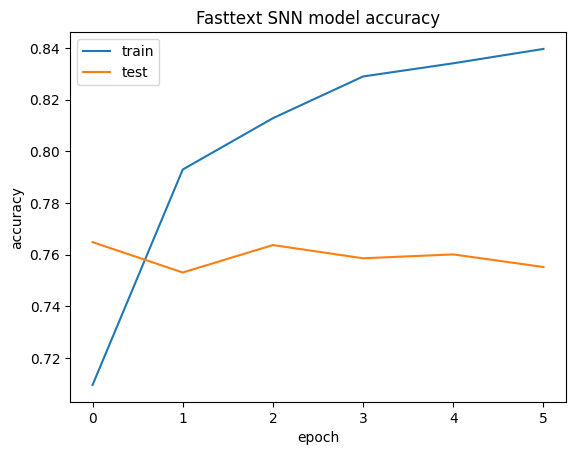

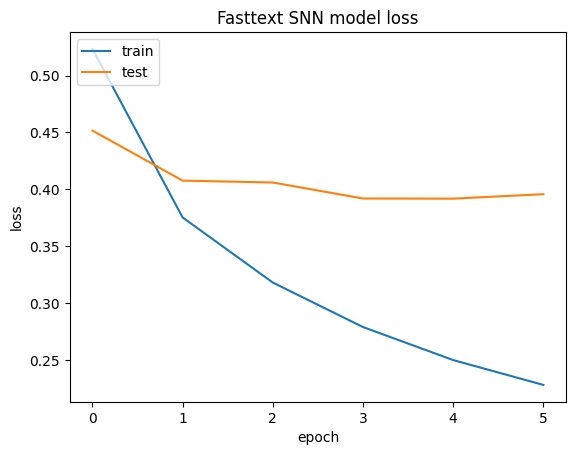

In [54]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(glove_snn_model_history.history['acc'])
plt.plot(glove_snn_model_history.history['val_acc'])

plt.title('Fasttext SNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(fasttext_snn_model_history.history['loss'])
plt.plot(fasttext_snn_model_history.history['val_loss'])

plt.title('Fasttext SNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# 2(a). Convolutional Neural Network with Glove Embedding

In [48]:
from keras.layers import Conv1D

In [49]:
# Neural Network architecture

glove_cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
glove_cnn_model.add(embedding_layer)

glove_cnn_model.add(Conv1D(128, 5, activation='relu'))
glove_cnn_model.add(GlobalMaxPooling1D())
glove_cnn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [50]:
# Model compiling

glove_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(glove_cnn_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [52]:
# Model training

glove_cnn_model_history = glove_cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - acc: 0.7153 - loss: 0.5449 - val_acc: 0.8330 - val_loss: 0.3848
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - acc: 0.8535 - loss: 0.3377 - val_acc: 0.8411 - val_loss: 0.3600
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - acc: 0.8907 - loss: 0.2790 - val_acc: 0.8535 - val_loss: 0.3381
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - acc: 0.9113 - loss: 0.2408 - val_acc: 0.8541 - val_loss: 0.3309
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - acc: 0.9337 - loss: 0.1976 - val_acc: 0.8495 - val_loss: 0.3407
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - acc: 0.9545 - loss: 0.1602 - val_acc: 0.8585 - val_loss: 0.3308


In [56]:
# Predictions on the Test Set

glove_cnn_score = glove_cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.8598 - loss: 0.3330


In [57]:
# Model Performance

print("Test Score:", glove_cnn_score[0])
print("Test Accuracy:", glove_cnn_score[1])

Test Score: 0.3314759135246277
Test Accuracy: 0.8597000241279602


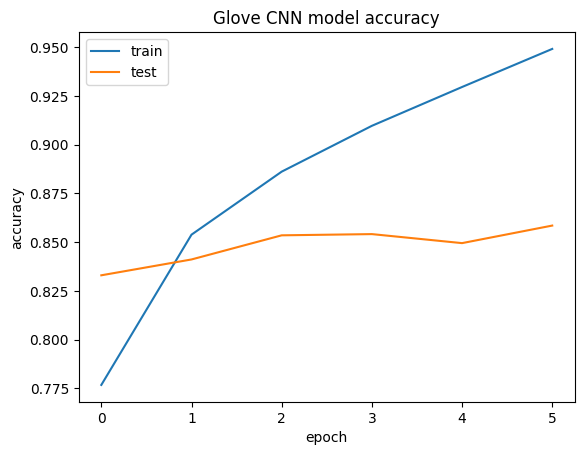

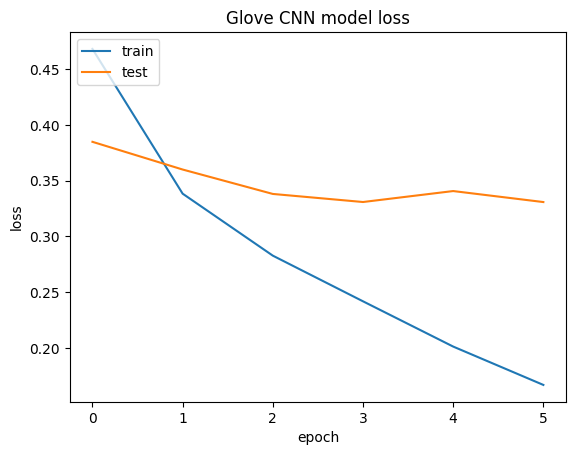

In [60]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(glove_cnn_model_history.history['acc'])
plt.plot(glove_cnn_model_history.history['val_acc'])

plt.title('Glove CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(glove_cnn_model_history.history['loss'])
plt.plot(glove_cnn_model_history.history['val_loss'])

plt.title('Glove CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# 2(b). Convolutional Neural Network with Fasttext Embedding

In [62]:
fasttext_cnn_model = Sequential()
fasttext_cnn_model.add(Embedding(vocab_length, 300, weights=[fasttext_embedding_matrix], input_length=maxlen, trainable=False))
fasttext_cnn_model.add(Conv1D(128, 5, activation='relu'))
fasttext_cnn_model.add(GlobalMaxPooling1D())
fasttext_cnn_model.add(Dense(1, activation='sigmoid'))

fasttext_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
fasttext_cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │    27,718,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,718,200 (105.74 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,718,200 (105.74 MB)

In [64]:
# Training Model
fasttext_cnn_model_history = fasttext_cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 269ms/step - acc: 0.7597 - loss: 0.5125 - val_acc: 0.8561 - val_loss: 0.3288
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 247ms/step - acc: 0.8793 - loss: 0.2930 - val_acc: 0.8680 - val_loss: 0.3088
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 270ms/step - acc: 0.9115 - loss: 0.2347 - val_acc: 0.8748 - val_loss: 0.2958
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 260ms/step - acc: 0.9356 - loss: 0.1856 - val_acc: 0.8813 - val_loss: 0.2873
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 260ms/step - acc: 0.9568 - loss: 0.1464 - val_acc: 0.8834 - val_loss: 0.2873
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 256ms/step - acc: 0.9775 - loss: 0.1074 - val_acc: 0.8746 - val_loss: 0.3062


In [65]:
# Predictions on the Test Set

fasttext_cnn_score = glove_cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.8598 - loss: 0.3330


In [66]:
# Model Performance

print("Fasttext CNN Test Score:", fasttext_cnn_score[0])
print("Fasttext CNN Test Accuracy:", fasttext_cnn_score[1])

Fasttext CNN Test Score: 0.3314759135246277
Fasttext CNN Test Accuracy: 0.8597000241279602


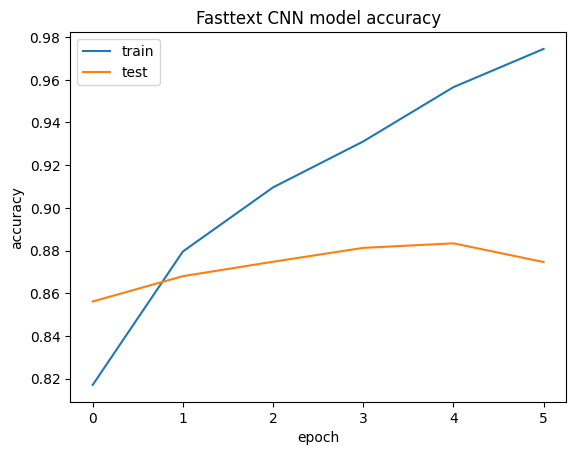

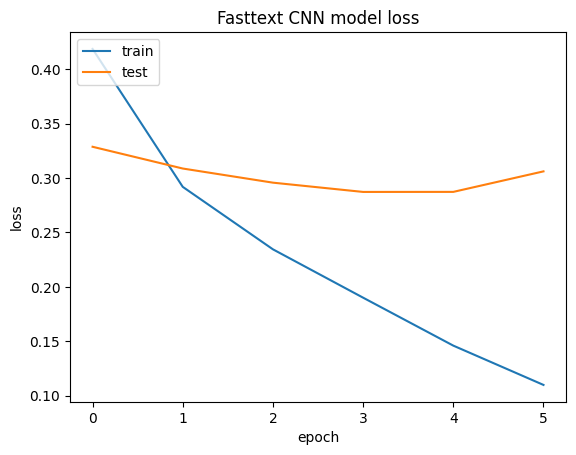

In [67]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(fasttext_cnn_model_history.history['acc'])
plt.plot(fasttext_cnn_model_history.history['val_acc'])

plt.title('Fasttext CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(fasttext_cnn_model_history.history['loss'])
plt.plot(fasttext_cnn_model_history.history['val_loss'])

plt.title('Fasttext CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# 3(a). Recurrent Neural Network (LSTM) with Glove Embedding

In [ ]:
from keras.layers import LSTM

In [74]:
# Neural Network architecture

glove_lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

glove_lstm_model.add(embedding_layer)
glove_lstm_model.add(LSTM(128))

glove_lstm_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [75]:
# Model compiling

glove_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(glove_lstm_model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

None


In [77]:
# Model Training

glove_lstm_model_history = glove_lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 346ms/step - acc: 0.7420 - loss: 0.5342 - val_acc: 0.8134 - val_loss: 0.4183
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 339ms/step - acc: 0.8097 - loss: 0.4253 - val_acc: 0.8367 - val_loss: 0.3714
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 309ms/step - acc: 0.8345 - loss: 0.3769 - val_acc: 0.8468 - val_loss: 0.3721
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 326ms/step - acc: 0.8561 - loss: 0.3425 - val_acc: 0.8451 - val_loss: 0.3452
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - acc: 0.8671 - loss: 0.3165 - val_acc: 0.8601 - val_loss: 0.3320
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - acc: 0.8701 - loss: 0.3116 - val_acc: 0.8660 - val_loss: 0.3173


In [ ]:
# Predictions on the Test Set

glove_LSTM_score = glove_lstm_model.evaluate(X_test, y_test, verbose=1)

In [78]:
# Model Performance

print("Glove LSTM Test Score:", glove_LSTM_score[0])
print("Glove LSTM Test Accuracy:", glove_LSTM_score[1])

Glove LSTM Test Score: 0.3261508643627167
Glove LSTM Test Accuracy: 0.8587999939918518


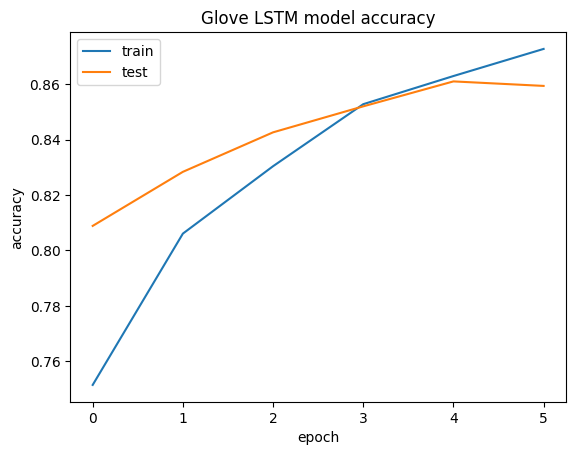

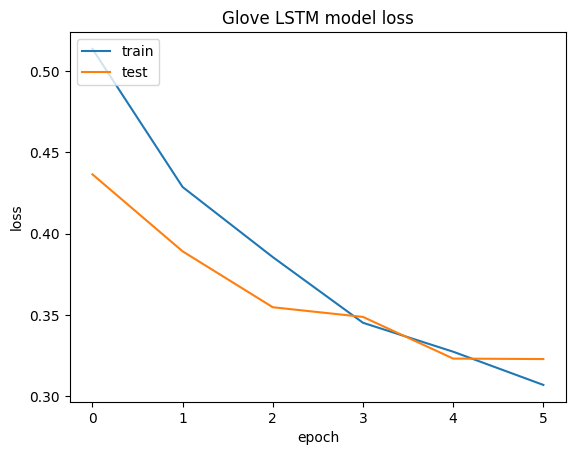

In [73]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(glove_lstm_model_history.history['acc'])
plt.plot(glove_lstm_model_history.history['val_acc'])

plt.title('Glove LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(glove_lstm_model_history.history['loss'])
plt.plot(glove_lstm_model_history.history['val_loss'])

plt.title('Glove LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [89]:
# Saving the model as a h5 file for possible use later

glove_lstm_model.save(f"./c1_glove_lstm_model_acc_{round(glove_LSTM_score[1], 3)}.h5", save_format='h5')

# 3(b). Recurrent Neural Network (LSTM) with Fasttext Embedding

In [80]:
fasttext_lstm_model = Sequential()
fasttext_lstm_model.add(Embedding(vocab_length, 300, weights=[fasttext_embedding_matrix], input_length=maxlen, trainable=False))
fasttext_lstm_model.add(LSTM(128))
fasttext_lstm_model.add(Dense(1, activation='sigmoid'))

fasttext_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
fasttext_lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │    27,718,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,718,200 (105.74 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,718,200 (105.74 MB)

In [81]:
# Training Model
fasttext_lstm_model_history = fasttext_lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 118s 462ms/step - acc: 0.7243 - loss: 0.5211 - val_acc: 0.8546 - val_loss: 0.3358
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 131s 420ms/step - acc: 0.8492 - loss: 0.3576 - val_acc: 0.8587 - val_loss: 0.3243
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 151s 455ms/step - acc: 0.8556 - loss: 0.3396 - val_acc: 0.8670 - val_loss: 0.3128
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 449ms/step - acc: 0.8638 - loss: 0.3206 - val_acc: 0.8708 - val_loss: 0.3097
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 415ms/step - acc: 0.8739 - loss: 0.3057 - val_acc: 0.8780 - val_loss: 0.3034
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 513ms/step - acc: 0.8773 - loss: 0.2980 - val_acc: 0.8816 - val_loss: 0.2870


In [82]:
# Predictions on the Test Set

fasttext_LSTM_score = fasttext_lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - acc: 0.8737 - loss: 0.2955


In [84]:
# Model Performance

print("Fasttext LSTM Test Score:", fasttext_LSTM_score[0])
print("Fasttext LSTM Test Accuracy:", fasttext_LSTM_score[1])

Fasttext LSTM Test Score: 0.2939155697822571
Fasttext LSTM Test Accuracy: 0.8758000135421753


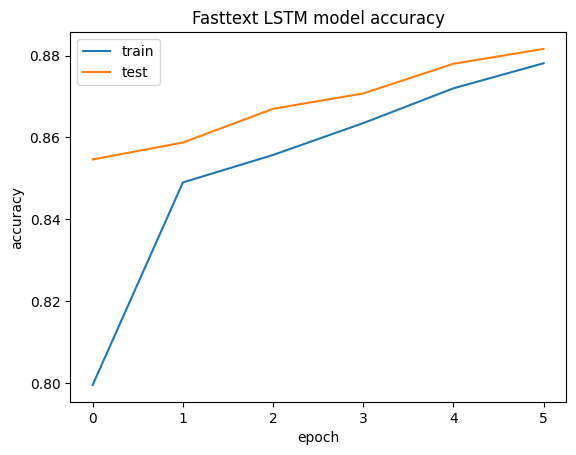

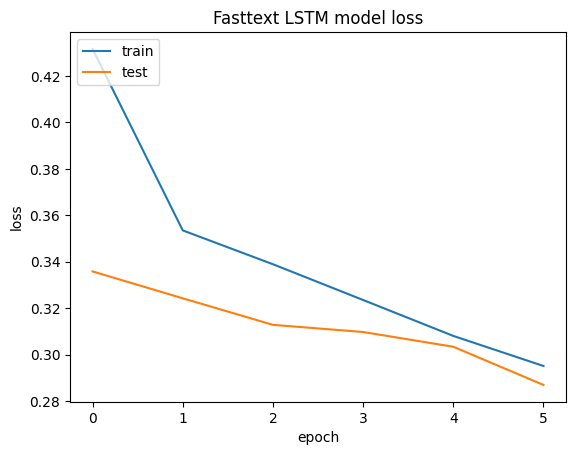

In [85]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(fasttext_lstm_model_history.history['acc'])
plt.plot(fasttext_lstm_model_history.history['val_acc'])

plt.title('Fasttext LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(fasttext_lstm_model_history.history['loss'])
plt.plot(fasttext_lstm_model_history.history['val_loss'])

plt.title('Fasttext LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [88]:
# Saving the model as a h5 file for possible use later

fasttext_lstm_model.save(f"./c2_fasttext_lstm_model_acc_{round(fasttext_LSTM_score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [ ]:
!ls # lists files in working directory

a1_IMDB_Dataset.csv	    b_SentimentAnalysis_with_NeuralNetwork.ipynb
a2_glove.6B.100d.txt	    c1_lstm_model_acc_0.856.h5
a3_IMDb_Unseen_Reviews.csv  c1_lstm_model_acc_0.864.h5


In [92]:
# Load previously trained LSTM Model

from tensorflow.keras.models import load_model

glove_pretrained_LSTM_model_path = '/content/c1_glove_lstm_model_acc_0.859.h5'
fasttext_pretrained_LSTM_model_path ='/content/c2_fasttext_lstm_model_acc_0.876.h5'

glove_pretrained_LSTM_model = load_model(glove_pretrained_LSTM_model_path)
fasttext_pretrained_LSTM_model = load_model(fasttext_pretrained_LSTM_model_path)



In [93]:
# summarize model.
glove_pretrained_LSTM_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (128, 100, 100)        │     9,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (128, 128)             │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,356,779 (35.69 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 9,239,400 (35.25 MB)

 Optimizer params: 2 (12.00 B)

In [94]:
# summarize model.
fasttext_pretrained_LSTM_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (128, 100, 300)        │    27,718,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (128, 128)             │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,937,979 (106.57 MB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 27,718,200 (105.74 MB)

 Optimizer params: 2 (12.00 B)

In [96]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv(dataset_path)

sample_reviews.head(6)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive


In [98]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['review']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [99]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [100]:
# Passing tokenised instance to the GLOVE LSTM model for predictions
glove_unseen_sentiments = glove_pretrained_LSTM_model.predict(unseen_padded)

glove_unseen_sentiments

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 62ms/step


array([[0.7058244 ],
       [0.9795534 ],
       [0.97368014],
       ...,
       [0.34029034],
       [0.07070974],
       [0.02072611]], dtype=float32)

In [101]:
# Passing tokenised instance to the FASTTEXT LSTM model for predictions
fasttext_unseen_sentiments = fasttext_pretrained_LSTM_model.predict(unseen_padded)

fasttext_unseen_sentiments

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 121s 77ms/step


array([[0.8702763 ],
       [0.98210347],
       [0.9764045 ],
       ...,
       [0.37815496],
       [0.06647485],
       [0.04439018]], dtype=float32)